In [1]:
import matplotlib.pyplot as plt
import pandas as pd

In [16]:
data = pd.read_csv("../../../data/class_credit_score_outliers_removed.csv", index_col="ID")

In [17]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Customer_ID,100000.0,6.250500e+03,3.608457e+03,1.000000,3.125750e+03,6.250500e+03,9.375250e+03,1.250000e+04
Name,100000.0,4.251251e+03,3.105459e+03,0.000000,1.432000e+03,4.006000e+03,6.876000e+03,1.013900e+04
Age,97219.0,3.332001e+01,1.076956e+01,14.000000,2.400000e+01,3.300000e+01,4.200000e+01,5.600000e+01
SSN,94428.0,5.003688e+08,2.906500e+08,81349.000000,2.452217e+08,5.003180e+08,7.557849e+08,9.999934e+08
Occupation,86851.0,8.030066e+04,2.958046e+04,29357.000000,6.034900e+04,9.068100e+04,9.916000e+04,1.515800e+05
Annual_Income,98977.0,5.046619e+04,3.824819e+04,7005.930000,1.933908e+04,3.699053e+04,7.163348e+04,1.793170e+05
Monthly_Inhand_Salary,84701.0,4.156814e+03,3.126004e+03,303.645417,1.623593e+03,3.081171e+03,5.920098e+03,1.461524e+04
Num_Bank_Accounts,98685.0,5.367624e+00,2.593839e+00,-1.000000,3.000000e+00,5.000000e+00,7.000000e+00,1.100000e+01
Num_Credit_Card,97729.0,5.533322e+00,2.067703e+00,0.000000,4.000000e+00,5.000000e+00,7.000000e+00,1.100000e+01
Interest_Rate,97966.0,1.453160e+01,8.739748e+00,1.000000,7.000000e+00,1.300000e+01,2.000000e+01,3.400000e+01


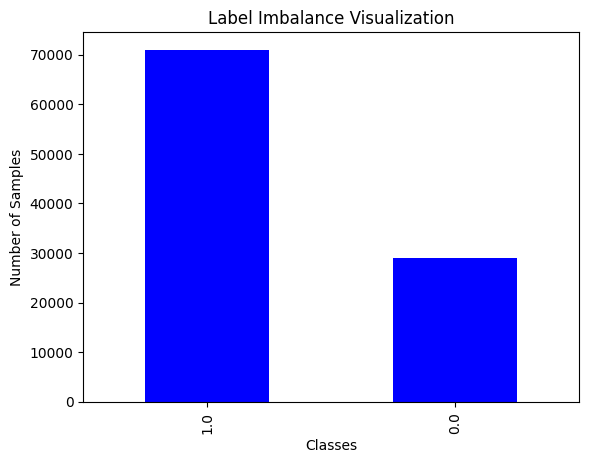

In [20]:
label_counts = data['Credit_Score'].value_counts()

label_counts.plot(kind='bar', color='blue')

plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('Label Imbalance Visualization')


plt.savefig(f"images/service_class_imbalance.png")

In [24]:
df_pos = data[data["Credit_Score"] == 0.0]
df_neg = data[data["Credit_Score"] == 1.0]

In [25]:
df_neg_sample = pd.DataFrame(df_neg.sample(len(df_pos)))
df_under = pd.concat([df_pos, df_neg_sample], axis=0)

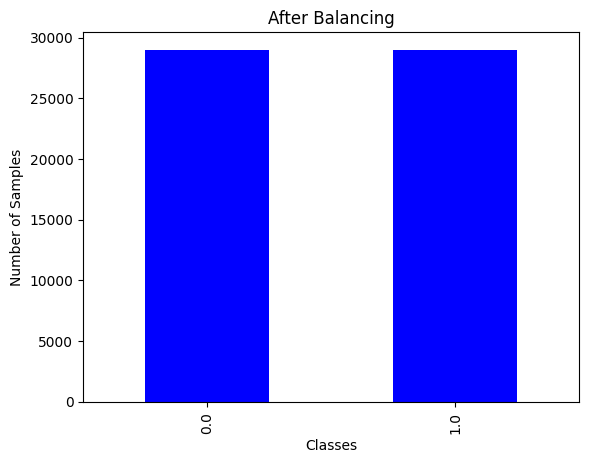

In [26]:
label_counts = df_under['Credit_Score'].value_counts()

label_counts.plot(kind='bar', color='blue')

plt.xlabel('Classes')
plt.ylabel('Number of Samples')
plt.title('After Balancing')


plt.savefig(f"images/service_class_balanced.png")